In [1]:
import pandas as pd

mnist_train = pd.read_csv('../data/mnist_train.csv',header=None)
mnist_test = pd.read_csv('../data/mnist_test.csv',header=None)

In [2]:
mnist_train.head()
X_train=mnist_train.loc[:,1:].values
y_train=mnist_train.loc[:,0].values
X_test=mnist_test.loc[:,1:].values
y_test=mnist_test.loc[:,0].values

X_train=X_train/255.
X_test=X_test/255.

print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

X_train: (60000, 784)
y_train: (60000,)
X_test: (10000, 784)
y_test: (10000,)


In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

inputs = tf.placeholder(tf.float32, [None, 784])
inputs_reshaped = tf.reshape(inputs, (-1,28,28,1))
y = tf.placeholder(tf.int64, [None, 1])
y_onehot = tf.one_hot(y, 10)
n_class=10
n_feature=512
# 构建中心
with tf.variable_scope('center'):
    centers = tf.get_variable('centers', [n_class, n_feature], dtype=tf.float32,\
                              initializer=tf.constant_initializer(0), trainable=False)

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
# 定义模型，复杂loss
from tensorflow.contrib.keras import layers

def VGG6(inputs, n_class=10, return_feature=False):
    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    features = layers.Dense(512, activation='relu', name='fc2')(x)
    outputs = layers.Dense(n_class, activation='softmax', name='predictions')(features)
    
    if return_feature:
        return outputs, features
    else:
        return outputs
    
def center_loss(features, label, alpha, nrof_classes):
    """Center loss based on the paper "A Discriminative Feature Learning Approach for Deep Face Recognition"
       (http://ydwen.github.io/papers/WenECCV16.pdf)
    """
    # 生成可以共享的变量centers
    with tf.variable_scope('center', reuse=True):
        centers = tf.get_variable('centers')
    label = tf.reshape(label, [-1])

    # 取出对应label下对应的center值，注意label里面的值可能会重复，因为一个标签下有可能会出现多个人
    centers_batch = tf.gather(centers, label)

    # 求特征点到中心的距离并乘以一定的系数，alfa是center的更新速度，越大代表更新的越慢
    diff = centers_batch - features

    # 获取一个batch中同一样本出现的次数，这里需要理解论文中的更新公式
    unique_label, unique_idx, unique_count = tf.unique_with_counts(label)
    appear_times = tf.gather(unique_count, unique_idx)
    appear_times = tf.reshape(appear_times, [-1, 1])

    diff = diff / tf.cast((1 + appear_times), tf.float32)
    diff = alpha * diff

    # 更新center，输出是将对应于label的centers减去对应的diff，如果同一个标签出现多次，那么就减去多次
    centers = tf.scatter_sub(centers, label, diff)

    # 求center loss，这里是将l2_loss里面的值进行平方相加，再除以2，并没有进行开方
    loss = tf.nn.l2_loss(features - centers_batch)
    
    return loss, centers

def island_loss(features, label, alpha, nrof_classes, nrof_features, lamda1=10):
    """Center loss based on the paper "Island Loss for Learning Discriminative Features in Facial Expression Recognition"
       (https://github.com/SeriaZheng/EmoNet/blob/master/loss_function/loss_paper/Island_loss.pdf)
    """
    # 生成可以共享的变量centers
    with tf.variable_scope('center', reuse=True):
        centers = tf.get_variable('centers')
    label = tf.reshape(label, [-1])

    # 取出对应label下对应的center值，注意label里面的值可能会重复，因为一个标签下有可能会出现多个人
    centers_batch = tf.gather(centers, label)

    # 求特征点到中心的距离并乘以一定的系数，diff1为center loss
    diff1 = centers_batch - features

    # 获取一个batch中同一样本出现的次数，这里需要理解论文中的更新公式
    unique_label, unique_idx, unique_count = tf.unique_with_counts(label)
    appear_times = tf.gather(unique_count, unique_idx)
    appear_times = tf.reshape(appear_times, [-1, 1])

    diff1 = diff1 / tf.cast((1 + appear_times), tf.float32)
    diff1 = alpha * diff1

    # diff2为island loss的center更新项
    diff2 = tf.get_variable('diff2', [nrof_classes, nrof_features], dtype=tf.float32,\
                              initializer=tf.constant_initializer(0), trainable=False)
    for i in range(nrof_classes):
        for j in range(nrof_classes):
            if i!=j:
                diff2 = tf.scatter_add(diff2, i,
                                       (tf.gather(centers, i) / tf.sqrt(
                                           tf.reduce_sum(tf.square(tf.gather(centers, i)))) * tf.sqrt(
                                           tf.reduce_sum(tf.square(tf.gather(centers, j)))))
                                       - tf.multiply(
                                           (tf.reduce_sum(
                                               tf.multiply(tf.gather(centers, i), tf.gather(centers, j))) / tf.sqrt(
                                               tf.reduce_sum(tf.square(tf.gather(centers, i)))) *
                                            tf.pow(tf.sqrt(tf.reduce_sum(tf.square(tf.gather(centers, j)))), 3)),
                                           tf.gather(centers, j)))
    diff2 = diff2 * lamda1 / (nrof_classes - 1)
    diff2 = alpha * diff2

    # 求center loss，这里是将l2_loss里面的值进行平方相加，再除以2，并没有进行开方
    loss1 = tf.nn.l2_loss(features - centers_batch)

    # 求island loss
    loss2 = tf.zeros(1)
    for i in range(nrof_classes):
        for j in range(nrof_classes):
            if i!=j:
                loss2 = tf.add(tf.add(tf.reduce_sum(tf.multiply(tf.gather(centers, i), tf.gather(centers, j))) / (
                        tf.sqrt(tf.reduce_sum(tf.square(tf.gather(centers, i)))) *
                        tf.sqrt(tf.reduce_sum(tf.square(tf.gather(centers, j))))), tf.ones(1)), loss2)
    loss2 = lamda1 * loss2

    loss = tf.add(loss1,loss2)

    # 更新center，输出是将对应于label的centers减去对应的diff，如果同一个标签出现多次，那么就减去多次(diff1与centers维度不同)
    centers = tf.scatter_sub(centers, label, diff1)
    # diff2维度与centers相同可以直接减
    centers = tf.subtract(centers, diff2)

    return loss, centers

In [5]:
# training graph
import numpy as np
# cal loss
preds,features = VGG6(inputs_reshaped, return_feature=True)
softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=y_onehot))
island_loss, update_centers = island_loss(features, y, 0.5, n_class, n_feature)
loss = tf.reduce_mean(softmax_loss + 0.01 * island_loss)

# cal acc
result = tf.argmax(preds,1)
ground_truth = tf.reshape(y, [-1])
correct_prediction = tf.equal(result, ground_truth)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# train
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

n_epochs=6
batch_size=128
n_batch = int(X_train.shape[0] / batch_size)
n_batch_val = int(X_test.shape[0] / batch_size)
sess.run(tf.global_variables_initializer())
for epoch in range(n_epochs):
    # training step
    index=np.arange(X_train.shape[0])
    np.random.shuffle(index)
    X_train=X_train[index,:]
    y_train=y_train[index]
    sum_loss=0
    sum_acc=0
    last_train_str=""
    for i in range(n_batch):
        x_temp=X_train[i*batch_size:(i+1)*batch_size,:]
        y_temp=y_train[i*batch_size:(i+1)*batch_size]
        y_temp=np.reshape(y_temp,(batch_size,1))
        feed_dict = {inputs: x_temp, y: y_temp}
        _,_,loss_value,acc_value=sess.run([train_step, update_centers, loss, accuracy], feed_dict=feed_dict)
        sum_loss+=loss_value
        sum_acc+=(acc_value*100)
        last_train_str = "\r[epoch:%d/%d, steps:%d/%d] -loss: %.4f - acc: %.2f%%" % \
              (epoch+1, n_epochs, i+1, n_batch, sum_loss/(i+1), sum_acc/(i+1))
        print(last_train_str, end='      ', flush=True)
    
    # validating step
    sum_loss=0
    sum_acc=0
    for i in range(n_batch_val):
        x_temp=X_test[i*batch_size:(i+1)*batch_size,:]
        y_temp=y_test[i*batch_size:(i+1)*batch_size]
        y_temp=np.reshape(y_temp,(batch_size,1))
        feed_dict = {inputs: x_temp, y: y_temp}
        loss_value,acc_value=sess.run([loss, accuracy], feed_dict=feed_dict)
        sum_loss+=loss_value
        sum_acc+=(acc_value*100)
        print(last_train_str+"  [validate:%d/%d] -loss: %.4f - acc: %.2f%%" % \
              (i+1, n_batch_val, sum_loss/(i+1), sum_acc/(i+1)), end='      ', flush=True)
    print('\n')

[epoch:1/6, steps:468/468] -loss: nan - acc: 65.68%  [validate:78/78] -loss: 14.3967 - acc: 81.41%      

[epoch:2/6, steps:468/468] -loss: 14.0710 - acc: 94.61%  [validate:78/78] -loss: 13.8294 - acc: 98.86%      

[epoch:3/6, steps:468/468] -loss: 13.7889 - acc: 98.89%  [validate:78/78] -loss: 13.7253 - acc: 99.11%      

[epoch:4/6, steps:468/468] -loss: 13.7089 - acc: 99.17%  [validate:78/78] -loss: 13.6985 - acc: 99.22%      

[epoch:5/6, steps:468/468] -loss: 13.6642 - acc: 99.32%  [validate:78/78] -loss: 13.6272 - acc: 99.31%      

[epoch:6/6, steps:468/468] -loss: 13.6316 - acc: 99.43%  [validate:78/78] -loss: 13.6182 - acc: 99.29%      



[feature extracting:5/5]      (640, 512)
(640, 2)


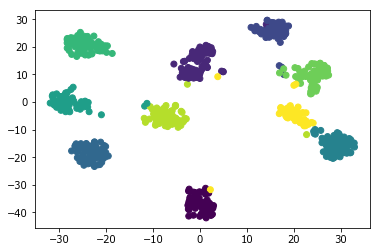

In [7]:
# crossentropy_loss 获取倒数第二层的特征 98.47%
index=np.arange(X_train.shape[0])
X_draw=X_train[index[0:640],:]
y_draw=y_train[index[0:640]]
mid_features=[]
n_batch=int(640/batch_size)
for i in range(n_batch):
    x_temp=X_draw[i*batch_size:(i+1)*batch_size,:]
    mid_feature_temp=sess.run([features], feed_dict={inputs:x_temp})
    mid_features.append(mid_feature_temp[0])
    print("\r[feature extracting:%d/%d]" % (i+1, n_batch), end='      ', flush=True)
mid_features=np.concatenate(mid_features, axis=0)
print(mid_features.shape)

#crossentropy_loss
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)
mid_features=tsne.fit_transform(mid_features)  #进行数据降维,降成两维
print(mid_features.shape)
from matplotlib import pyplot as plt
plt.scatter(x=mid_features[:,0],y=mid_features[:,1],c=y_draw)
plt.show()

[feature extracting:5/5]      (640, 512)
(640, 2)


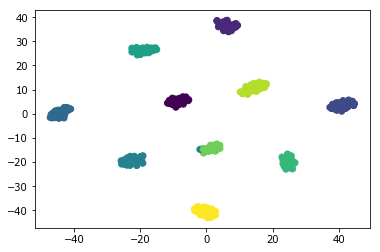

In [12]:
# center_loss 获取倒数第二层的特征 99.30%
index=np.arange(X_train.shape[0])
X_draw=X_train[index[0:640],:]
y_draw=y_train[index[0:640]]
mid_features=[]
n_batch=int(640/batch_size)
for i in range(n_batch):
    x_temp=X_draw[i*batch_size:(i+1)*batch_size,:]
    mid_feature_temp=sess.run([features], feed_dict={inputs:x_temp})
    mid_features.append(mid_feature_temp[0])
    print("\r[feature extracting:%d/%d]" % (i+1, n_batch), end='      ', flush=True)
mid_features=np.concatenate(mid_features, axis=0)
print(mid_features.shape)

#crossentropy_loss
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)
mid_features=tsne.fit_transform(mid_features)  #进行数据降维,降成两维
print(mid_features.shape)
from matplotlib import pyplot as plt
plt.scatter(x=mid_features[:,0],y=mid_features[:,1],c=y_draw)
plt.show()

[feature extracting:5/5]      (640, 512)
(640, 2)


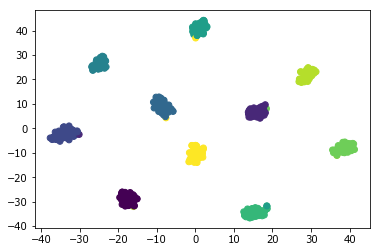

In [6]:
# island_loss 获取倒数第二层的特征 99.29%
index=np.arange(X_train.shape[0])
X_draw=X_train[index[0:640],:]
y_draw=y_train[index[0:640]]
mid_features=[]
n_batch=int(640/batch_size)
for i in range(n_batch):
    x_temp=X_draw[i*batch_size:(i+1)*batch_size,:]
    mid_feature_temp=sess.run([features], feed_dict={inputs:x_temp})
    mid_features.append(mid_feature_temp[0])
    print("\r[feature extracting:%d/%d]" % (i+1, n_batch), end='      ', flush=True)
mid_features=np.concatenate(mid_features, axis=0)
print(mid_features.shape)

#crossentropy_loss
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)
mid_features=tsne.fit_transform(mid_features)  #进行数据降维,降成两维
print(mid_features.shape)
from matplotlib import pyplot as plt
plt.scatter(x=mid_features[:,0],y=mid_features[:,1],c=y_draw)
plt.show()